In [2]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

In [8]:
from helper_functions import unzip_data, walk_through_dir, plot_loss_curves, create_tensorboard_callback, pred_and_plot

In [2]:
walk_through_dir("data/101_food_classes_10_percent")

There are 2 directories and 0 images in 'data/101_food_classes_10_percent'.
There are 101 directories and 0 images in 'data/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/donuts'.
Th

In [2]:
import tensorflow as tf

train_dir = "data/101_food_classes_10_percent/train"
test_dir = "data/101_food_classes_10_percent/test"

In [3]:
IMAGE_SHAPE = (224,224)
BATCH=32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, image_size=IMAGE_SHAPE, batch_size=BATCH, 
                                                                            label_mode="categorical")


test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, image_size=IMAGE_SHAPE, batch_size=BATCH,
                                                                           shuffle=False,
                                                                            label_mode="categorical")

Found 7575 files belonging to 101 classes.
Metal device set to: Apple M1 Pro


2023-03-20 08:17:41.776415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-20 08:17:41.776556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 25250 files belonging to 101 classes.


In [4]:
# temp

train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [3]:
from tensorflow.keras.layers.experimental import preprocessing

data_agumentation =  tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)

], name="data_agumentation")

In [4]:
def create_checkpoint_callback(filepath):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath,
        verbose = 1,
        save_weights_only = True,
        save_best_only=True,
        save_freq='epoch'
    )

In [5]:
#  Model 0 using keras functional api

base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, # top is output layer we want to change it to 10 classes
    )
base_model.trainable = False

inputs =  tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# resnet50v2 needs rescaling, not for efficientnet as they have rescaling builtin 
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/.255)(inputs)

x = data_agumentation(inputs)
print(x.shape)

x = base_model(x, training=False)
print(x.shape)



#  average pooling our outputs from base model to get most important models.
x = tf.keras.layers.GlobalAveragePooling2D(name="gloable_average_pooling2d")(x)
x.shape

# output activation layers
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss='CategoricalCrossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')
model_0.summary()

# history_model_0 = model_0.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent), validation_data=test_data_10_percent, 
#                        validation_steps=(0.25 * len(test_data_10_percent)), callbacks=[create_checkpoint_callback("06_model_0"), create_tensorboard_callback(dir_name="tensorboard_hub_06", experiment_name="06_model_0")])


model_0.load_weights("06_model_0")

(None, 224, 224, 3)
(None, 7, 7, 1280)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_agumentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gloable_average_pooling2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,95

In [11]:
#  Model 1 using keras functional api without data augmentation

base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, # top is output layer we want to change it to 10 classes
    )
base_model.trainable = False

inputs =  tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# resnet50v2 needs rescaling, not for efficientnet as they have rescaling builtin 
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/.255)(inputs)

x = inputs
print(x.shape)

x = base_model(x, training=False)
print(x.shape)



#  average pooling our outputs from base model to get most important models.
x = tf.keras.layers.GlobalAveragePooling2D(name="gloable_average_pooling2d")(x)
x.shape

# output activation layers
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='CategoricalCrossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')
model_1.summary()


history_model_1 = model_1.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent), validation_data=test_data_10_percent, 
                       validation_steps=(0.25 * len(test_data_10_percent)), callbacks=[create_checkpoint_callback("06_model_1"), create_tensorboard_callback(dir_name="tensorboard_hub_06", experiment_name="06_model_1")])

(None, 224, 224, 3)
(None, 7, 7, 1280)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gloable_average_pooling2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________
Saving TensorBoard log files to: tensorboard_hub_06/06_model_1/2023031

2023-03-12 18:18:11.176372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


237/237 [==============================] - ETA: 0s - loss: 3.0821 - accuracy: 0.3438

2023-03-12 18:18:39.497613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 2.09838, saving model to 06_model_1
237/237 [==============================] - 53s 203ms/step - loss: 3.0821 - accuracy: 0.3438 - val_loss: 2.0984 - val_accuracy: 0.5371
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 1.7543 - accuracy: 0.6082
Epoch 2: val_loss improved from 2.09838 to 1.69880, saving model to 06_model_1
237/237 [==============================] - 46s 192ms/step - loss: 1.7543 - accuracy: 0.6082 - val_loss: 1.6988 - val_accuracy: 0.5878
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.3490 - accuracy: 0.6944
Epoch 3: val_loss improved from 1.69880 to 1.55937, saving model to 06_model_1
237/237 [==============================] - 45s 190ms/step - loss: 1.3490 - accuracy: 0.6944 - val_loss: 1.5594 - val_accuracy: 0.6023
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.1078 - accuracy: 0.7488
Epoch 4: val_loss improved from 1.55937 to 1.48884, saving model to 06_model_1


In [12]:
base_model.trainable = False

for layer in base_model.layers[:-10]:
    layer.trainable = True

In [13]:
model_1.compile(loss='CategoricalCrossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics='accuracy')

In [14]:
history_model_2 = model_1.fit(train_data_10_percent, epochs=10, steps_per_epoch=len(train_data_10_percent), validation_data=test_data_10_percent, 
            initial_epoch=history_model_1.epoch[-1],
                       validation_steps=(0.25 * len(test_data_10_percent)), callbacks=[create_tensorboard_callback(dir_name="tensorboard_hub_06", experiment_name="06_model_2")])

Saving TensorBoard log files to: tensorboard_hub_06/06_model_2/20230312-182532
Epoch 5/10


2023-03-12 18:25:35.448819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


237/237 [==============================] - ETA: 0s - loss: 0.7737 - accuracy: 0.8511

2023-03-12 18:26:03.885760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


237/237 [==============================] - 54s 205ms/step - loss: 0.7737 - accuracy: 0.8511 - val_loss: 1.4268 - val_accuracy: 0.6271
Epoch 6/10
237/237 [==============================] - 45s 189ms/step - loss: 0.7511 - accuracy: 0.8597 - val_loss: 1.4255 - val_accuracy: 0.6261
Epoch 7/10
237/237 [==============================] - 45s 188ms/step - loss: 0.7356 - accuracy: 0.8644 - val_loss: 1.4183 - val_accuracy: 0.6269
Epoch 8/10
237/237 [==============================] - 45s 190ms/step - loss: 0.7211 - accuracy: 0.8679 - val_loss: 1.4249 - val_accuracy: 0.6269
Epoch 9/10
237/237 [==============================] - 46s 192ms/step - loss: 0.7071 - accuracy: 0.8712 - val_loss: 1.4179 - val_accuracy: 0.6283
Epoch 10/10
237/237 [==============================] - 46s 194ms/step - loss: 0.6935 - accuracy: 0.8752 - val_loss: 1.4176 - val_accuracy: 0.6285


In [15]:
model_1.save_weights("fine_tunned_06_model_1")

In [16]:
model_1.trainable = False

In [17]:
for layer in model_1.layers:
    print(layer.name, layer.trainable)

input_layer False
efficientnetb0 False
gloable_average_pooling2d False
output_layer False


In [18]:
!tensorboard dev upload --logdir ./tensorboard_hub_06 --name "06"    --description "101 tt " --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/HbmTYupbTginzIQeya3QTw/

[2023-03-13T07:09:49] Started scanning logdir.
[2023-03-13T07:10:38] Total uploaded: 114 scalars, 0 tensors, 6 binary objects (4.9 MB)
[2023-03-13T07:10:38] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/HbmTYupbTginzIQeya3QTw/


In [19]:
model_1.load_weights("fine_tunned_06_model_1")

In [20]:
model_1.evaluate(test_data_10_percent)

790/790 [==============================] - 77s 92ms/step - loss: 1.3800 - accuracy: 0.6363


[1.3799537420272827, 0.6362772583961487]

In [49]:
pred_probs = model_1.predict(test_data_10_percent, verbose=1)

790/790 [==============================] - 67s 85ms/step


In [22]:
790*32

25280

In [23]:
pred_probs.shape

(25250, 101)

In [28]:
pred_probs[:1], sum(pred_probs[1])

(array([[9.1729645e-04, 1.0036057e-02, 1.2154585e-03, 7.4271869e-04,
         5.5487580e-03, 1.2829877e-03, 6.6251778e-06, 2.8315838e-04,
         2.6356371e-03, 5.7175546e-04, 8.4650156e-04, 1.0529389e-03,
         4.1007128e-04, 2.4750819e-03, 5.3805119e-04, 1.0097147e-03,
         1.3072395e-03, 7.7093180e-05, 5.9140786e-03, 5.8755704e-04,
         5.5553438e-03, 1.4060065e-04, 9.2460796e-05, 1.0571266e-05,
         1.0669340e-04, 1.6364247e-03, 5.1816605e-02, 1.6825583e-05,
         1.2877068e-03, 5.4145430e-06, 5.0967489e-04, 1.1550061e-04,
         2.9879546e-05, 2.7653899e-05, 3.4030693e-04, 2.8159444e-03,
         3.6651012e-03, 1.3752039e-01, 2.3704860e-03, 2.8824145e-03,
         1.5556889e-05, 4.5154803e-04, 5.4016907e-04, 1.0925574e-03,
         4.7199099e-04, 1.3527072e-05, 7.7439880e-04, 1.7481440e-03,
         1.9977476e-04, 1.0071675e-03, 4.7430661e-02, 1.8606746e-05,
         2.0089364e-03, 4.1413018e-03, 1.7535729e-05, 2.6516936e-05,
         6.1742766e-03, 5.3934235e

In [30]:
tf.argmax(pred_probs[1])

<tf.Tensor: shape=(), dtype=int64, numpy=52>

In [32]:
test_data_10_percent.class_names[52]

'gyoza'

In [50]:
pred_classes = pred_probs.argmax(axis=1)

In [51]:
pred_classes[:10]

array([49,  0,  0,  0,  0, 78, 29, 46,  2, 41])

In [52]:
# Unbatch the data
y_lables = []

for images, labels in test_data_10_percent.unbatch():
    y_lables.append(labels.numpy().argmax())
y_lables

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [53]:
y_lables[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Visual evalaute, confusion matrix, accuracy, classification report

In [54]:
from sklearn.metrics import accuracy_score

accuracy_score(y_lables, pred_classes)

0.6362772277227723

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_lables, pred_classes)

In [56]:
cm

array([[ 67,   1,  21, ...,   5,   2,  10],
       [  0, 162,   0, ...,   0,   1,   0],
       [ 11,   1, 168, ...,   3,   1,   0],
       ...,
       [  1,   0,   2, ..., 141,   0,   2],
       [  1,   1,   0, ...,   0,  77,   0],
       [  4,   0,   2, ...,   2,   1, 161]])

In [80]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, vertical=False, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

    Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70)  # create enough axis slots for each class and rotate

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
          plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
        else:
          plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [82]:
make_confusion_matrix(y_lables, pred_classes, classes=test_data_10_percent.class_names, figsize=(100,100), text_size=20, savefig=True)

### classification_report


In [83]:
from sklearn.metrics import classification_report

In [86]:
print(classification_report(y_lables, pred_classes))

              precision    recall  f1-score   support

           0       0.37      0.27      0.31       250
           1       0.64      0.65      0.64       250
           2       0.65      0.67      0.66       250
           3       0.63      0.65      0.64       250
           4       0.50      0.46      0.48       250
           5       0.50      0.47      0.48       250
           6       0.75      0.79      0.77       250
           7       0.80      0.81      0.81       250
           8       0.40      0.39      0.40       250
           9       0.58      0.58      0.58       250
          10       0.50      0.49      0.49       250
          11       0.64      0.66      0.65       250
          12       0.68      0.62      0.65       250
          13       0.61      0.56      0.58       250
          14       0.60      0.59      0.59       250
          15       0.43      0.37      0.40       250
          16       0.65      0.65      0.65       250
          17       0.50    

In [87]:
classification_report_dict = classification_report(y_lables, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3701657458563536,
  'recall': 0.268,
  'f1-score': 0.31090487238979114,
  'support': 250},
 '1': {'precision': 0.6403162055335968,
  'recall': 0.648,
  'f1-score': 0.6441351888667992,
  'support': 250},
 '2': {'precision': 0.6511627906976745,
  'recall': 0.672,
  'f1-score': 0.6614173228346458,
  'support': 250},
 '3': {'precision': 0.6342412451361867,
  'recall': 0.652,
  'f1-score': 0.6429980276134122,
  'support': 250},
 '4': {'precision': 0.4978165938864629,
  'recall': 0.456,
  'f1-score': 0.4759916492693111,
  'support': 250},
 '5': {'precision': 0.4978902953586498,
  'recall': 0.472,
  'f1-score': 0.48459958932238195,
  'support': 250},
 '6': {'precision': 0.75,
  'recall': 0.792,
  'f1-score': 0.7704280155642024,
  'support': 250},
 '7': {'precision': 0.8023715415019763,
  'recall': 0.812,
  'f1-score': 0.8071570576540756,
  'support': 250},
 '8': {'precision': 0.4016393442622951,
  'recall': 0.392,
  'f1-score': 0.3967611336032389,
  'support': 250},
 '9'

In [90]:
class_f1_scores = {}
for k,v in classification_report_dict.items():
    if k == "accuracy":
        break
    class_f1_scores[test_data_10_percent.class_names[int(k)]]= v["f1-score"]
class_f1_scores

{'apple_pie': 0.31090487238979114,
 'baby_back_ribs': 0.6441351888667992,
 'baklava': 0.6614173228346458,
 'beef_carpaccio': 0.6429980276134122,
 'beef_tartare': 0.4759916492693111,
 'beet_salad': 0.48459958932238195,
 'beignets': 0.7704280155642024,
 'bibimbap': 0.8071570576540756,
 'bread_pudding': 0.3967611336032389,
 'breakfast_burrito': 0.5771543086172344,
 'bruschetta': 0.4939271255060729,
 'caesar_salad': 0.6469428007889546,
 'cannoli': 0.65,
 'caprese_salad': 0.5833333333333334,
 'carrot_cake': 0.592741935483871,
 'ceviche': 0.40086206896551724,
 'cheese_plate': 0.6467065868263473,
 'cheesecake': 0.4384787472035794,
 'chicken_curry': 0.4989247311827957,
 'chicken_quesadilla': 0.6804123711340208,
 'chicken_wings': 0.7333333333333334,
 'chocolate_cake': 0.5384615384615385,
 'chocolate_mousse': 0.38554216867469876,
 'churros': 0.7404426559356135,
 'clam_chowder': 0.7290448343079922,
 'club_sandwich': 0.690566037735849,
 'crab_cakes': 0.4853228962818004,
 'creme_brulee': 0.74509803

In [96]:
import pandas as pd

f1_score = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1_scores": list(class_f1_scores.values())}).sort_values("f1_scores", ascending=False)

In [97]:
f1_score[:10]

class_names  f1_scores
33              edamame   0.979757
63             macarons   0.898129
75                  pho   0.857143
91  spaghetti_carbonara   0.845588
51            guacamole   0.841699
54    hot_and_sour_soup   0.841300
69              oysters   0.836224
32            dumplings   0.834951
64            miso_soup   0.824219
68          onion_rings   0.821643

/var/folders/0j/5__hz27s6d5gvt1vgl8zpwpw0000gn/T/ipykernel_6659/1331048671.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


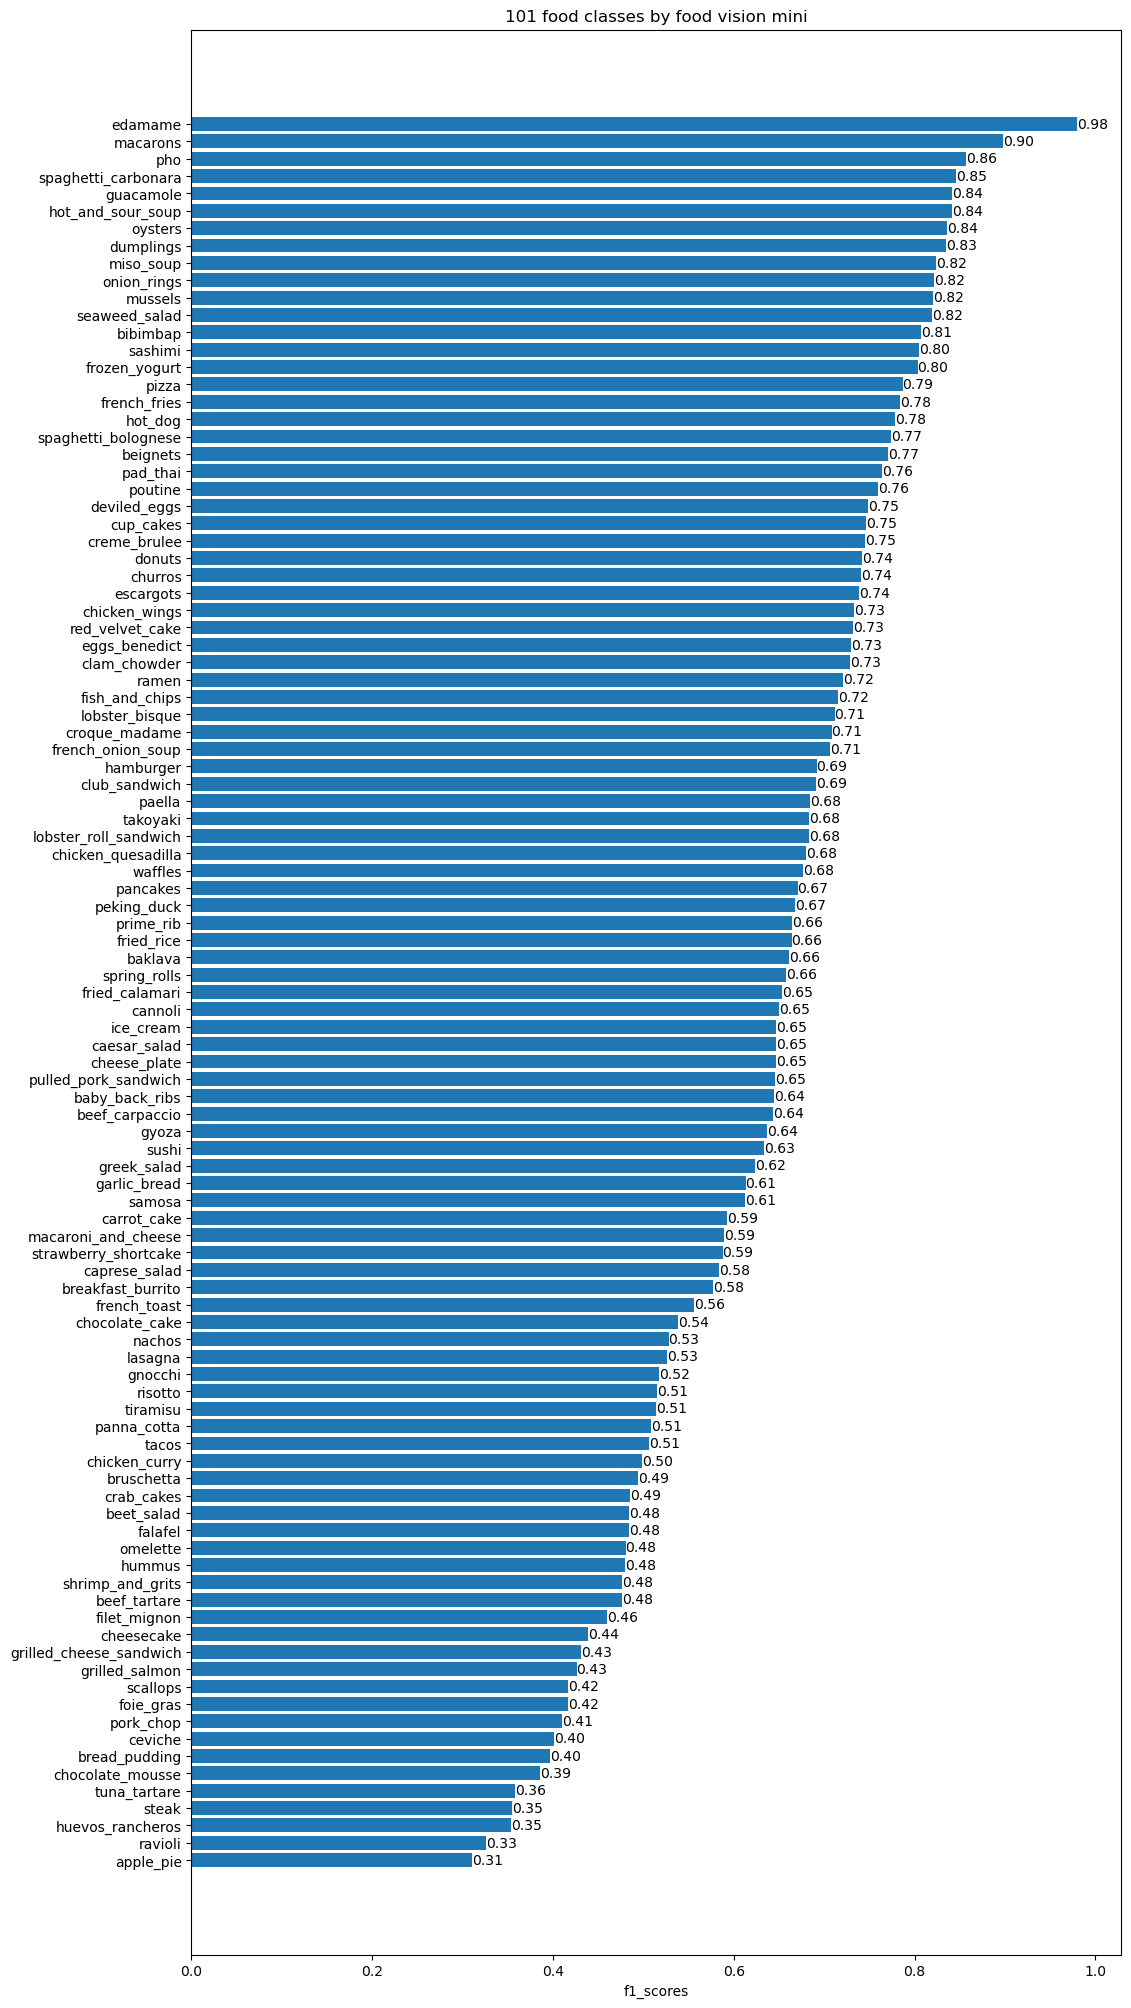

In [121]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_score)), f1_score["f1_scores"].values)
ax.set_yticks(range(len(f1_score)))
ax.set_yticklabels(f1_score["class_names"])
ax.set_xlabel("f1_scores")
ax.set_title("101 food classes by food vision mini")
ax.invert_yaxis()

plt.bar_label(scores,[ "{:0.2f}".format(x) for x in f1_score['f1_scores'].values ] )
fig.show()

## Custom prediction

- load using tf.io.read_file()
- decode to tensor tf.io.decode_images()
- rescale
- convert value bettern 0 and 1 if required. effientnet handles this.

In [223]:
def load_and_prep_image(filename, img_shape=224, scale=True):
    img = tf.io.read_file(filename)
  # Decode it into a tensor
    img = tf.image.decode_jpeg(img)
  # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
    # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img
        

- random test image
- prep image 
- plot image and prediction

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

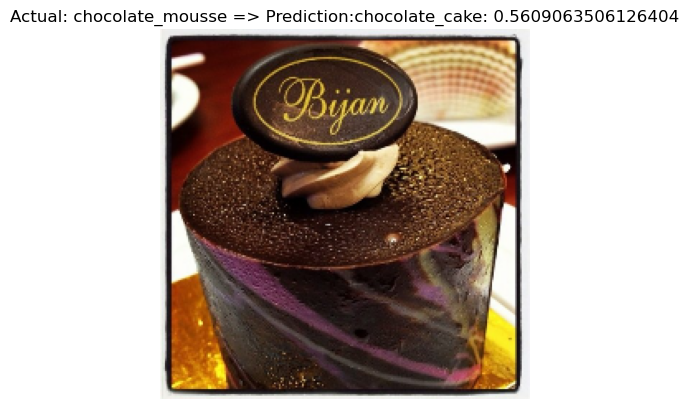

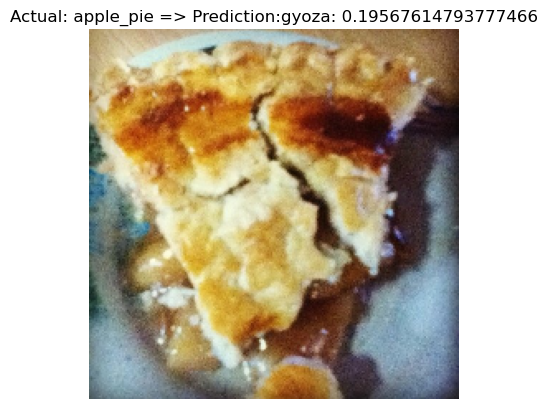

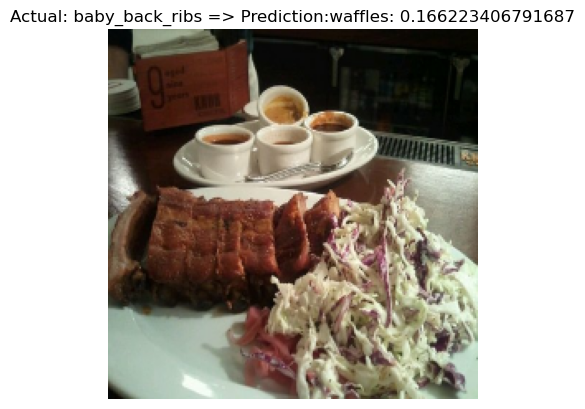

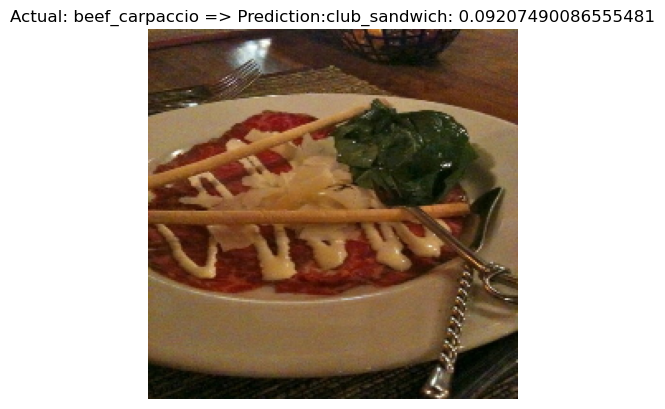

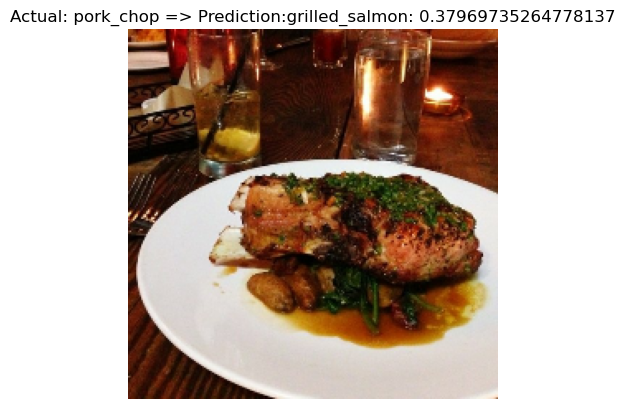

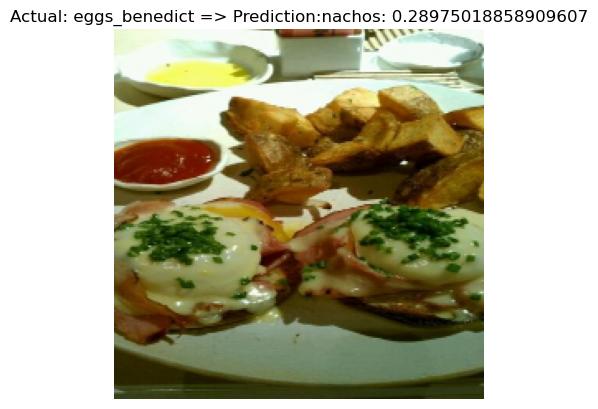

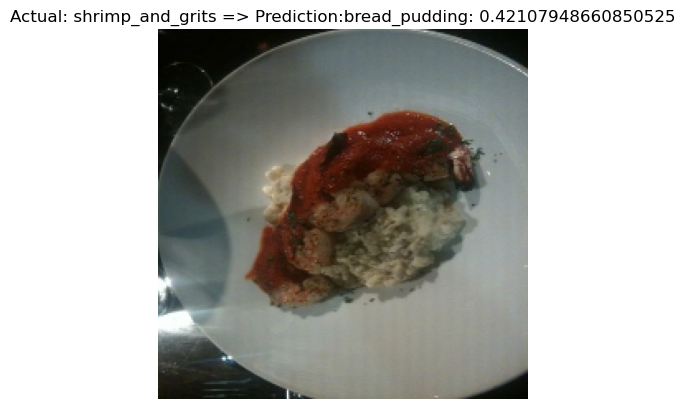

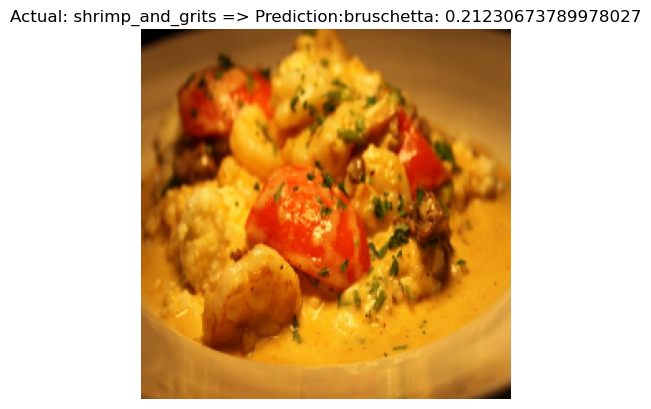

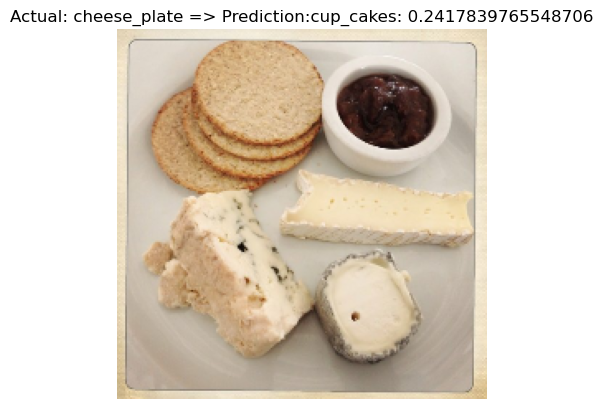

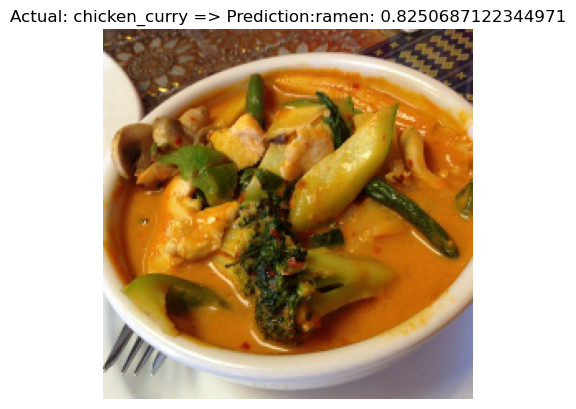

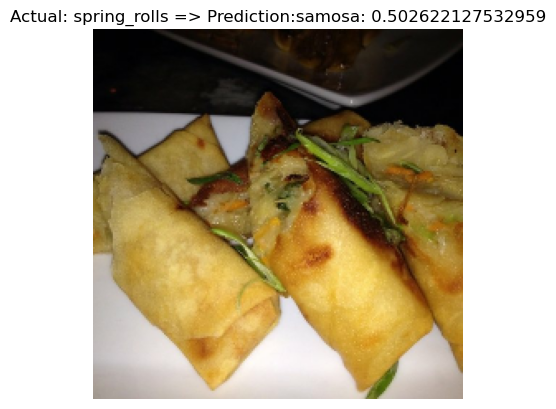

<Figure size 640x480 with 0 Axes>

In [147]:
import random
import os

def view_random_image(target_dir, target_classes):
    print(target_classes)
    def get_pred():
        orignial_class = random.choice(target_classes)
        print(orignial_class)
        target_folder = target_dir + orignial_class
        random_choice = random.sample(os.listdir(target_folder), 1)

        print(target_folder + "/" + random_choice[0])
        img, imgr = load_and_prep_image(target_folder + "/" + random_choice[0], scale=False)

        pred = model_1.predict(tf.expand_dims(imgr, axis=0))
        pred_class = target_classes[pred.argmax()]
        print(pred_class)
        
        img = tf.io.read_file(target_folder + "/" + random_choice[0])
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [224, 224])
        img = img/255.
        return pred_class, orignial_class, img, pred[0][pred.argmax()]
    
    pred_class, orignial_class, img, prob = get_pred()
    
    count = 0
    while True:
        if pred_class != orignial_class:
        
            plt.imshow(img)
            plt.title(f"Actual: {orignial_class} => Prediction:{pred_class}: {prob}")
            plt.axis(False);
            plt.figure()
            count+=1
            if count>10:
                return
        pred_class, orignial_class, img, prob= get_pred()
        

view_random_image(test_dir + "/",test_data_10_percent.class_names)

## Finding wrong predictions
- list all test files
- dataframe to get filepath, ground truth, prediction, probability
- find wrong predictions
- sort wrong predictions
- visualize wrong predictions

In [192]:
file_names = list(tf.data.Dataset.list_files("./data/101_food_classes_10_percent/test/*/*.jpg", shuffle=False).as_numpy_iterator())

In [197]:
file_names[:10]

[b'./data/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'./data/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [181]:
# test_data_10_percent.class_names, y_lables, pred_classes, pred_probs

list

In [194]:
import pandas as pd

get_class_name = lambda t: test_data_10_percent.class_names[t]
vfunc = np.vectorize(get_class_name)

df = pd.DataFrame({"file_names": file_names,
              "ground_truth": y_lables,
              "ground_class": vfunc(y_lables),
              "prediction": pred_classes,
              "prediction_class": vfunc(pred_classes),
              "probability": pred_probs.max(axis=1),
             })

In [206]:
top_wrong = df[df["ground_truth"]!=df["prediction"]].sort_values("probability", ascending=False)

In [227]:
top_wrong


file_names  ground_truth  \
11642  b'./data/101_food_classes_10_percent/test/garl...            46   
10690  b'./data/101_food_classes_10_percent/test/fren...            42   
7059   b'./data/101_food_classes_10_percent/test/croq...            28   
5339   b'./data/101_food_classes_10_percent/test/choc...            21   
17816  b'./data/101_food_classes_10_percent/test/pael...            71   
...                                                  ...           ...   
16477  b'./data/101_food_classes_10_percent/test/muss...            65   
1147   b'./data/101_food_classes_10_percent/test/beef...             4   
1024   b'./data/101_food_classes_10_percent/test/beef...             4   
751    b'./data/101_food_classes_10_percent/test/beef...             3   
15564  b'./data/101_food_classes_10_percent/test/maca...            62   

              ground_class  prediction  prediction_class  probability  
11642         garlic_bread          10        bruschetta     0.986178  
10690         french_toast           6          beignets     0.982734  
7059         croque_madame          46      garlic_bread     0.974336  
5339        chocolate_cake          83   red_velvet_cake     0.969618  
17816               paella          70          pad_thai     0.966055  
...                    ...         ...               ...          ...  
16477              mussels          89  shrimp_and_grits     0.072490  
1147          beef_tartare          30      deviled_eggs     0.072404  
1024          beef_tartare          57            hummus     0.071506  
751         beef_carpaccio          13     caprese_salad     0.061231  
15564  macaroni_and_cheese          50    grilled_salmon     0.057031  

[9184 rows x 6 columns]

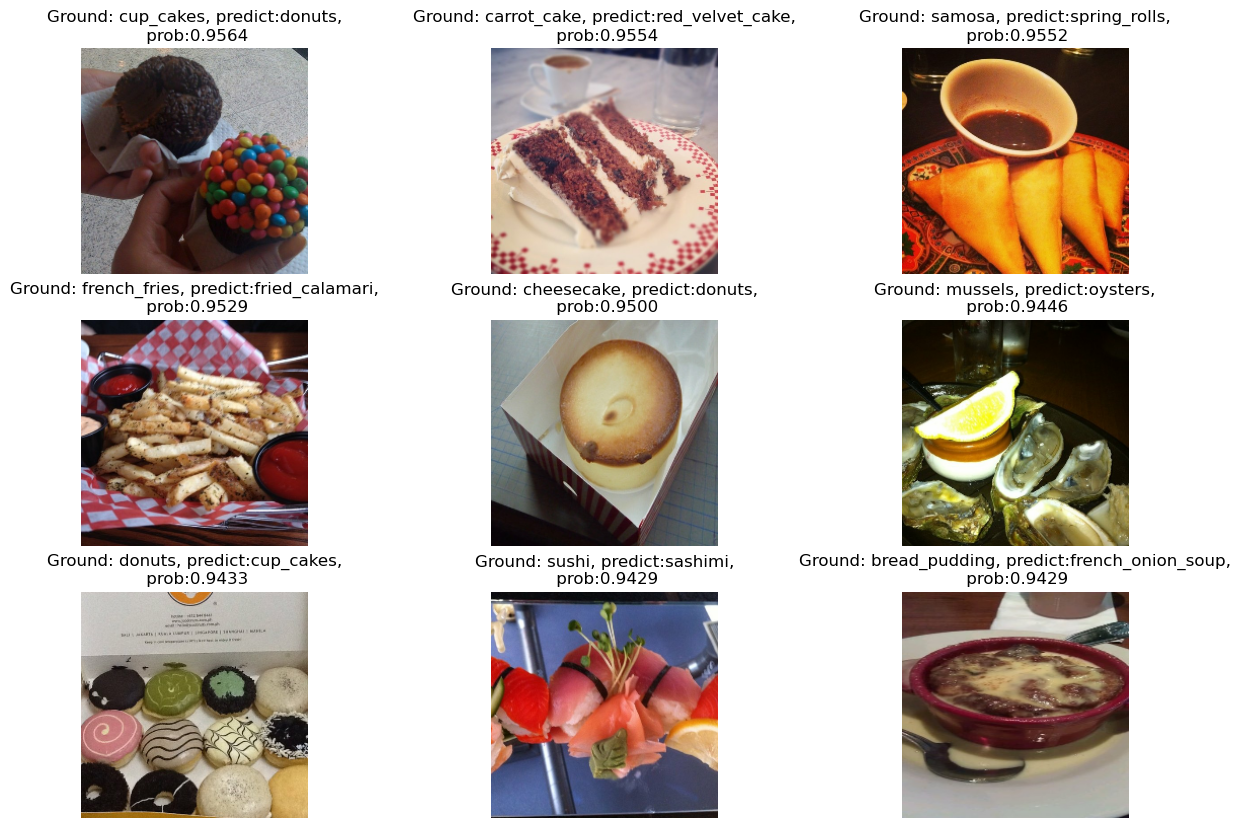

In [236]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

def load_and_prep_image(filename, img_shape=224, scale=True):
    img = tf.io.read_file(filename)
  # Decode it into a tensor
    img = tf.image.decode_jpeg(img)
  # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
    # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img
    
start =10
total = 9

for i, row in enumerate(top_wrong[start: start+total].itertuples()):
    plt.subplot(3,3,i+1)
    imgr = load_and_prep_image(row[1], scale=True)
    plt.imshow(imgr)
    plt.title(f"Ground: {row[3]}, predict:{row[5]},\n prob:{row[6]:.4f}")
    plt.axis(False)
    

In [237]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2023-03-18 19:44:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.193.128, 172.253.116.128, 209.85.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  6.32MB/s    in 2.0s    

2023-03-18 19:44:51 (6.32 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [241]:
# import zipfile 
# zip_ref = zipfile.ZipFile("custom_food_images.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

In [243]:
file_names = list(tf.data.Dataset.list_files("./data/custom_food_images/*.jpeg", shuffle=False).as_numpy_iterator())

In [244]:
file_names

[b'./data/custom_food_images/chicken_wings.jpeg',
 b'./data/custom_food_images/hamburger.jpeg',
 b'./data/custom_food_images/pizza-dad.jpeg',
 b'./data/custom_food_images/ramen.jpeg',
 b'./data/custom_food_images/steak.jpeg',
 b'./data/custom_food_images/sushi.jpeg']

1/1 [==============================] - 0s 38ms/step


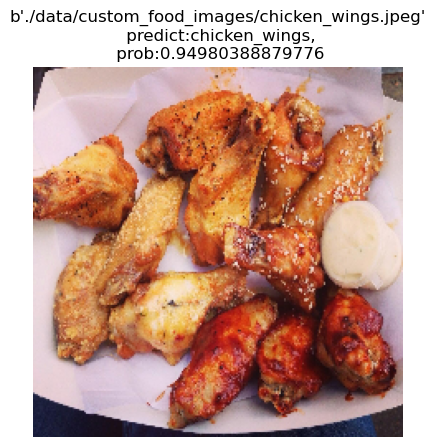

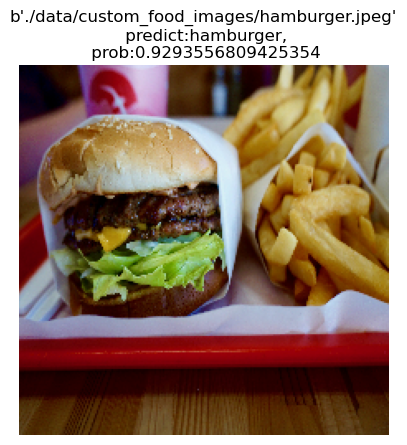

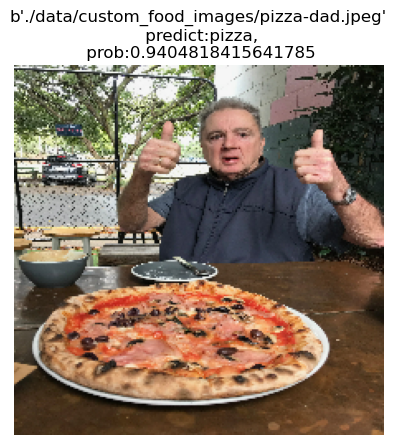

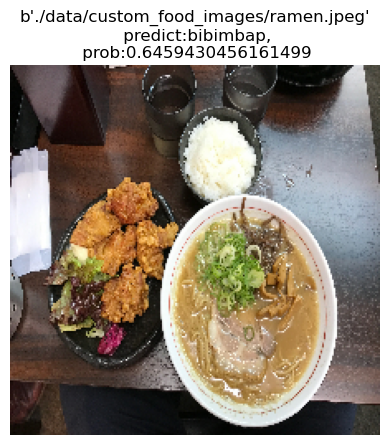

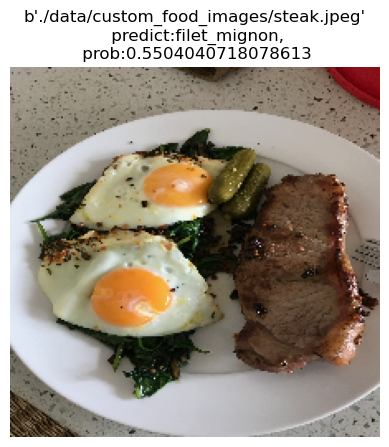

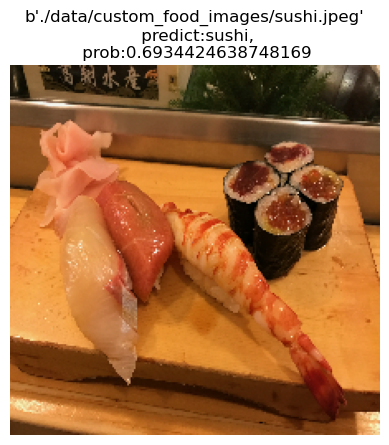

<Figure size 640x480 with 0 Axes>

In [257]:
# plt.figure(figsize=(1,10))

for file in file_names:
    img = load_and_prep_image(file, scale=False)
    pred_probs = model_1.predict(tf.expand_dims(img, axis=0))
    class_name = test_data_10_percent.class_names[pred_probs.argmax()]
    plt.imshow(img/255.)
    plt.title(f"{file}\n predict:{class_name},\n prob:{pred_probs.max()}")
    plt.axis(False)
    plt.figure()
    
    